In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import cv2
import os

In [2]:
# Load train and test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
# Display basic information about the datasets
print("Train Dataset Info:")
print(train_df.info())
print("\nTest Dataset Info:")
print(test_df.info())

Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55489 entries, 0 to 55488
Columns: 176 entries, id to X3112_sd
dtypes: float64(54), int64(122)
memory usage: 74.5 MB
None

Test Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13873 entries, 0 to 13872
Columns: 164 entries, id to VOD_X_1997_2018_multiyear_mean_m12
dtypes: float64(42), int64(122)
memory usage: 17.4 MB
None


### Searching for missing values

As can be seen below, the dataset can be considered as almost complete, with mostly no missing values. Only the standard values of the target values are missing 29.44% of the data. We decide to produce two different datasets, one that does not use the missing values and one that fills them in with the mean value.

In [4]:
# Check for missing values in the train DataFrame
train_missing_values = train_df.isnull().sum()
print("Missing values in Train DataFrame:")
print(train_missing_values)

Missing values in Train DataFrame:
id                                                                           0
WORLDCLIM_BIO1_annual_mean_temperature                                       0
WORLDCLIM_BIO12_annual_precipitation                                         0
WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month        0
WORLDCLIM_BIO15_precipitation_seasonality                                    0
                                                                         ...  
X11_sd                                                                   16341
X18_sd                                                                   16341
X26_sd                                                                   16341
X50_sd                                                                   16341
X3112_sd                                                                 16341
Length: 176, dtype: int64


In [5]:
# Check for missing values in the test DataFrame
test_missing_values = test_df.isnull().sum()
print("\nMissing values in Test DataFrame:")
print(test_missing_values)


Missing values in Test DataFrame:
id                                                                       0
WORLDCLIM_BIO1_annual_mean_temperature                                   0
WORLDCLIM_BIO12_annual_precipitation                                     0
WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month    0
WORLDCLIM_BIO15_precipitation_seasonality                                0
                                                                        ..
VOD_X_1997_2018_multiyear_mean_m08                                       0
VOD_X_1997_2018_multiyear_mean_m09                                       0
VOD_X_1997_2018_multiyear_mean_m10                                       0
VOD_X_1997_2018_multiyear_mean_m11                                       0
VOD_X_1997_2018_multiyear_mean_m12                                       0
Length: 164, dtype: int64


### Log the values

If we look at the targets, we can see that it is better to use log10 for them, otherwise it is difficult to distinguish them.

array([[<Axes: title={'center': 'X11_mean'}>,
        <Axes: title={'center': 'X18_mean'}>,
        <Axes: title={'center': 'X26_mean'}>],
       [<Axes: title={'center': 'X50_mean'}>,
        <Axes: title={'center': 'X3112_mean'}>,
        <Axes: title={'center': 'X4_sd'}>],
       [<Axes: title={'center': 'X11_sd'}>,
        <Axes: title={'center': 'X18_sd'}>,
        <Axes: title={'center': 'X26_sd'}>],
       [<Axes: title={'center': 'X50_sd'}>,
        <Axes: title={'center': 'X3112_sd'}>, <Axes: >]], dtype=object)

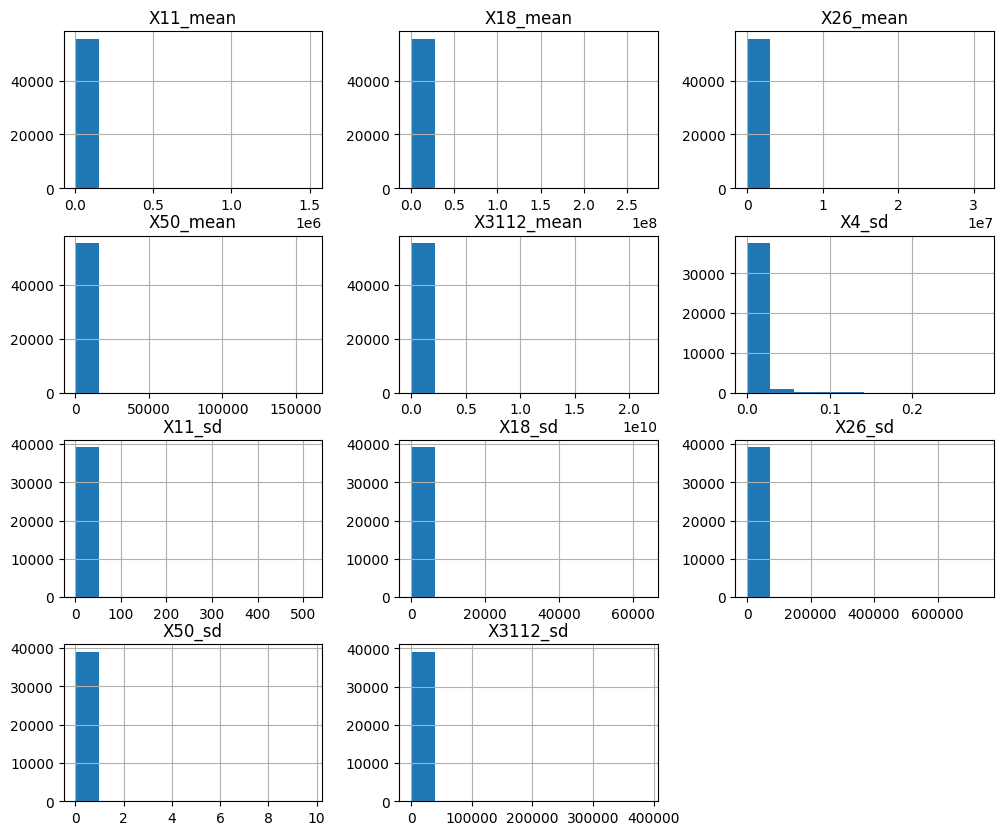

In [6]:
# List of columns to apply log10 transformation
columns_to_log = ['X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean',
                  'X4_sd', 'X11_sd', 'X18_sd', 'X26_sd', 'X50_sd', 'X3112_sd']

# Visualize the distribution of log-transformed variables in the train DataFrame
train_df[columns_to_log].hist(figsize=(12, 10))

**The target variables don't have a nice distribution, so I use log10 on them**

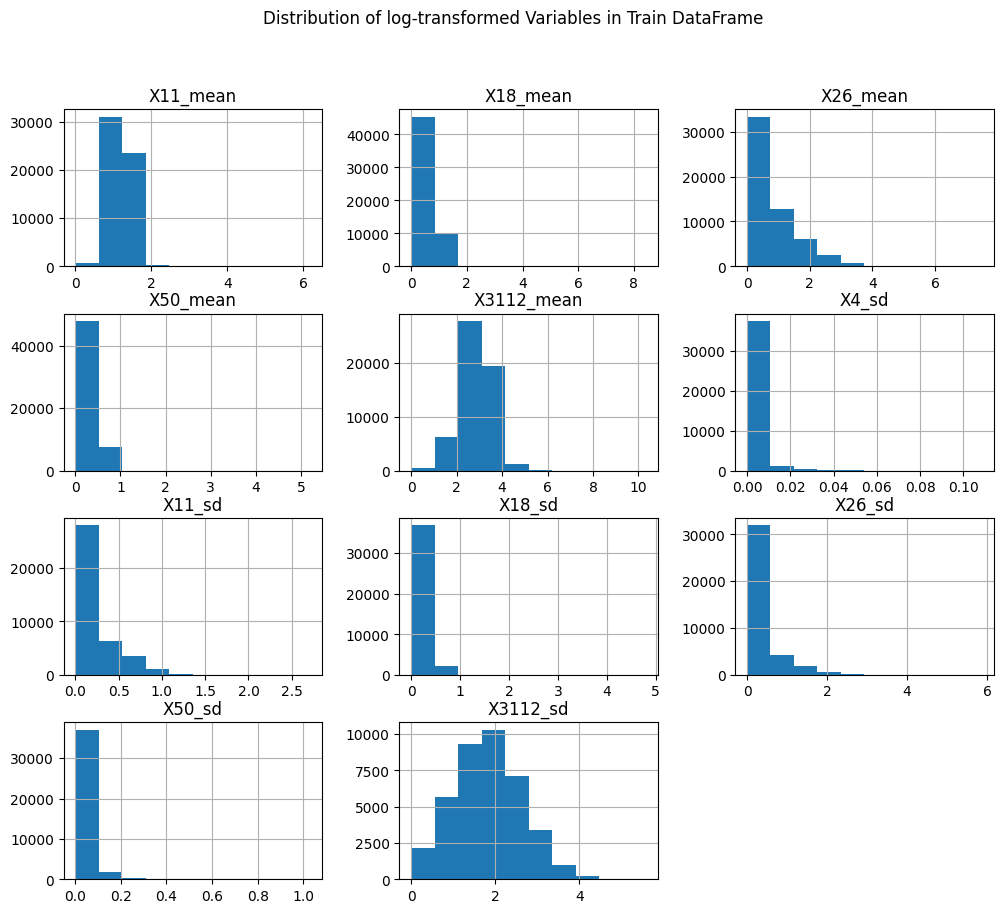

In [7]:
# Apply log10 transformation to the specified columns
for column in columns_to_log:
    train_df[column] = np.log10(train_df[column] + 1)  # Adding 1 to avoid log(0)

# Visualize the distribution of log-transformed variables in the train DataFrame
train_df[columns_to_log].hist(figsize=(12, 10))
plt.suptitle("Distribution of log-transformed Variables in Train DataFrame")
plt.show()

### Detecting outliers

Most of the variables has a standard divination, and has less then 7.5% outliers. Only the Modis values has more, but if we inspect them closer, we can see, that they has a power distibution, so it is acceptable.

In [8]:
# Define a function to detect outliers using the IQR method
def detect_outliers(df, columns):
    outliers = {}
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        column_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers[column] = column_outliers
    return outliers

# List of columns to check for outliers
columns_to_check = train_df.columns

# Detect outliers in every column
outliers = detect_outliers(train_df, columns_to_check)

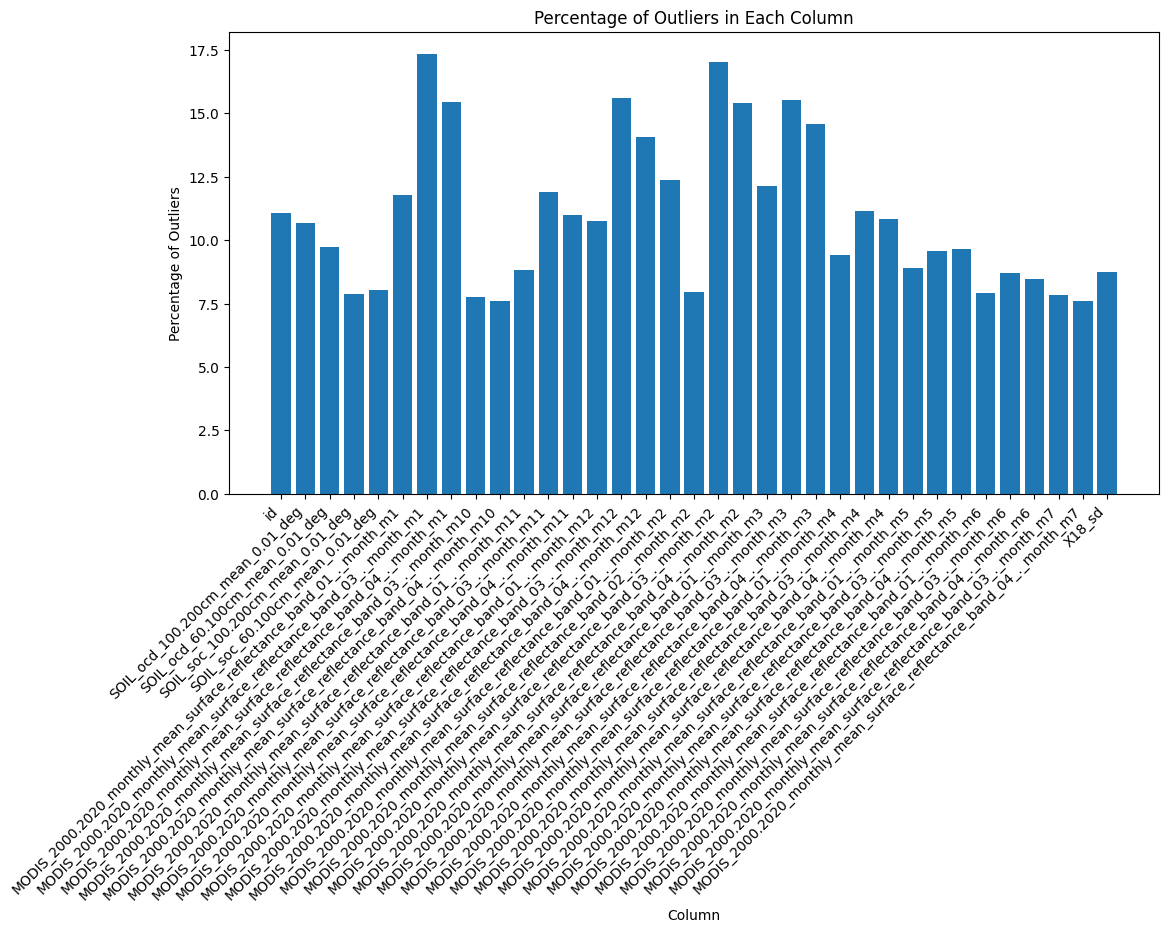

In [9]:
min_percentage = 7.5

# Define a function to calculate the percentage of outliers in each column
def calculate_outlier_percentage(df, outliers):
    outlier_percentages = {}
    total_samples = len(df)
    for column, outlier_df in outliers.items():
        outlier_count = len(outlier_df)
        outlier_percentage = (outlier_count / total_samples) * 100
        if outlier_percentage > min_percentage:
            outlier_percentages[column] = outlier_percentage
    return outlier_percentages

# Calculate the percentage of outliers for each column
outlier_percentages = calculate_outlier_percentage(train_df, outliers)

# Plot a bar chart to visualize the percentage of outliers for each column
plt.figure(figsize=(12, 6))
plt.bar(outlier_percentages.keys(), outlier_percentages.values())
plt.title("Percentage of Outliers in Each Column")
plt.xlabel("Column")
plt.ylabel("Percentage of Outliers")
plt.xticks(rotation=45, ha='right')
plt.show()


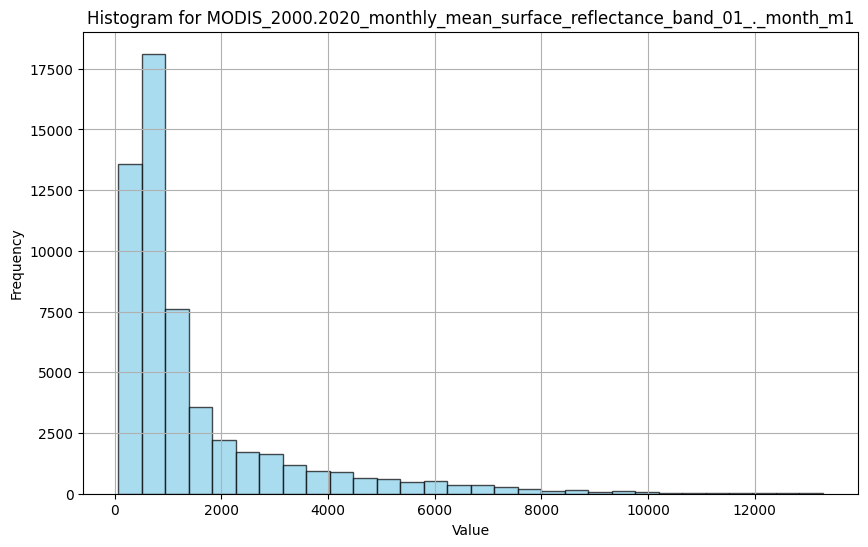

In [10]:
# Specify the column to visualize
column = "MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1"

# Plot a histogram of the data
plt.figure(figsize=(10, 6))
plt.hist(train_df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title(f"Histogram for {column}")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### Joint distributions and covariance matrices

#### Target variables

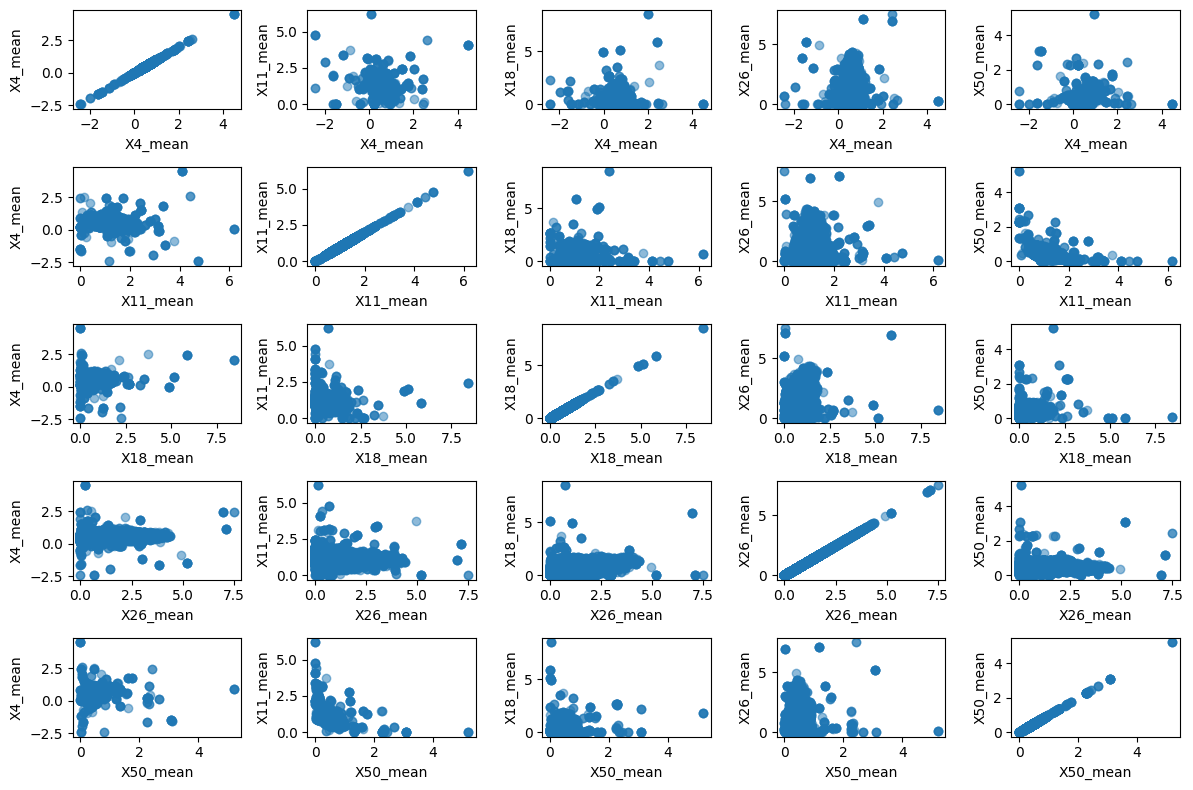

In [11]:
# Specify the columns for joint distribution
columns_for_joint_distribution = ['X4_mean','X11_mean', 'X18_mean', 'X26_mean', 'X50_mean']

# Plot joint distributions using scatter plots
plt.figure(figsize=(12, 8))
for i, column1 in enumerate(columns_for_joint_distribution):
    for j, column2 in enumerate(columns_for_joint_distribution):
        plt.subplot(len(columns_for_joint_distribution), len(columns_for_joint_distribution), i * len(columns_for_joint_distribution) + j + 1)
        plt.scatter(train_df[column1], train_df[column2], alpha=0.5)
        plt.xlabel(column1)
        plt.ylabel(column2)
plt.tight_layout()
plt.show()


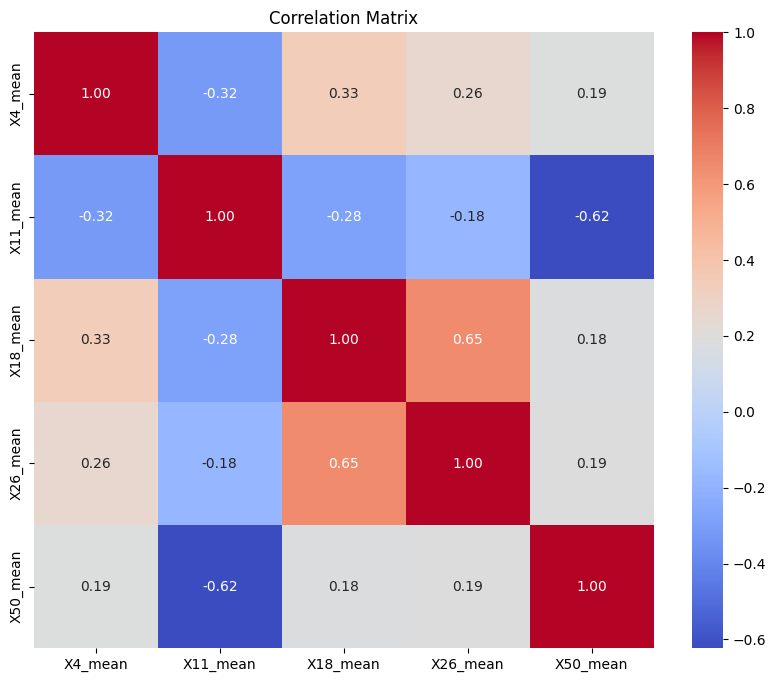

In [15]:
# Specify the columns for which you want to compute the correlation
columns_for_correlation = ['X4_mean','X11_mean', 'X18_mean', 'X26_mean', 'X50_mean']

# Compute the correlation matrix
correlation_matrix = train_df[columns_for_correlation].corr()

# Define custom labels for the columns
custom_labels = ['X4_mean','X11_mean', 'X18_mean', 'X26_mean', 'X50_mean']

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=custom_labels, yticklabels=custom_labels)
plt.title("Correlation Matrix")
plt.show()

#### Word Clim

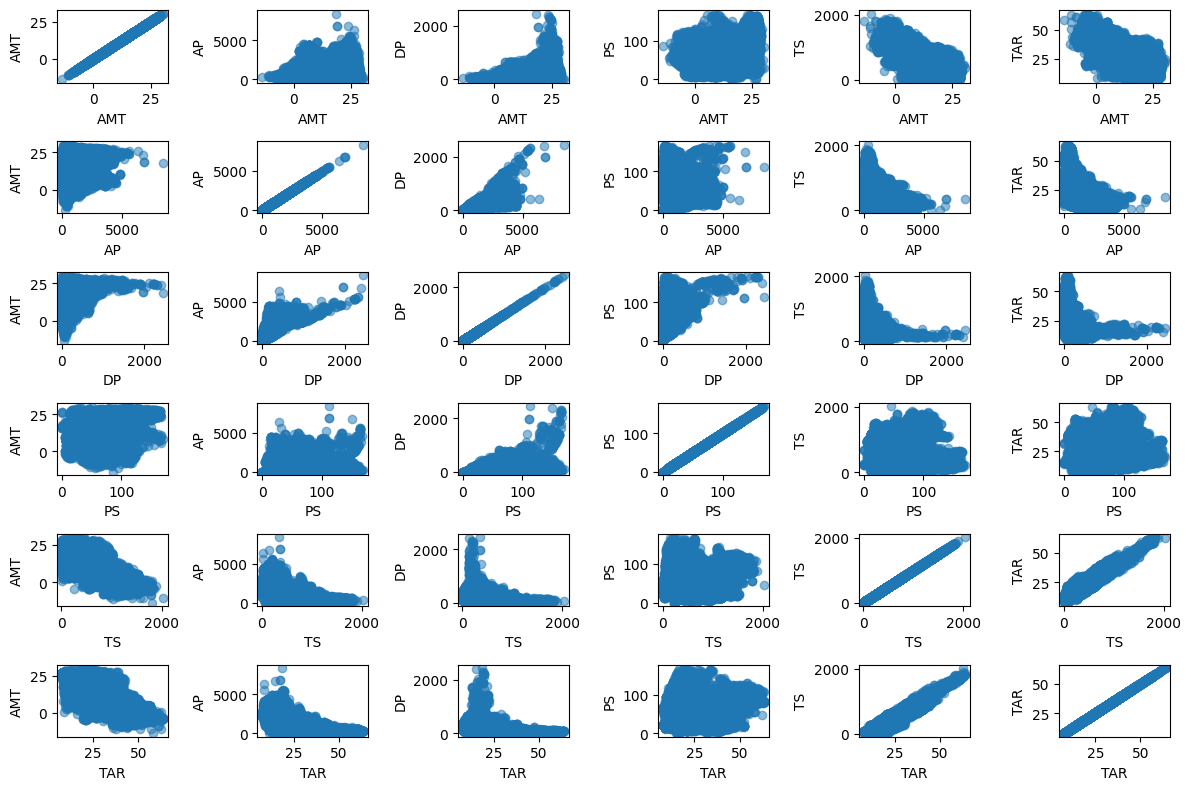

In [19]:
# Specify the columns for joint distribution
columns_for_joint_distribution = ['WORLDCLIM_BIO1_annual_mean_temperature', 'WORLDCLIM_BIO12_annual_precipitation', 'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month', 
                                  'WORLDCLIM_BIO15_precipitation_seasonality', 'WORLDCLIM_BIO4_temperature_seasonality', 'WORLDCLIM_BIO7_temperature_annual_range']

# Custom labels for the columns
custom_labels = ['AMT', 'AP', 'DP', 'PS', 'TS', 'TAR']

# Plot joint distributions using scatter plots
plt.figure(figsize=(12, 8))
for i, column1 in enumerate(columns_for_joint_distribution):
    for j, column2 in enumerate(columns_for_joint_distribution):
        plt.subplot(len(columns_for_joint_distribution), len(columns_for_joint_distribution), i * len(columns_for_joint_distribution) + j + 1)
        plt.scatter(train_df[column1], train_df[column2], alpha=0.5)
        plt.xlabel(custom_labels[i])
        plt.ylabel(custom_labels[j])
plt.tight_layout()
plt.show()



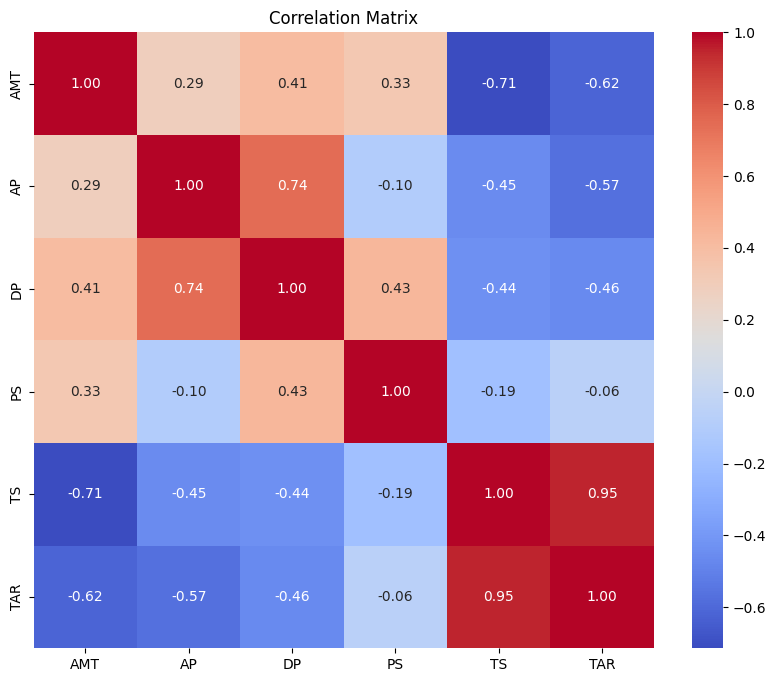

In [18]:
# Specify the columns for which you want to compute the correlation
columns_for_correlation = ['WORLDCLIM_BIO1_annual_mean_temperature', 'WORLDCLIM_BIO12_annual_precipitation', 'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month', 
                                  'WORLDCLIM_BIO15_precipitation_seasonality', 'WORLDCLIM_BIO4_temperature_seasonality', 'WORLDCLIM_BIO7_temperature_annual_range']

# Compute the correlation matrix
correlation_matrix = train_df[columns_for_correlation].corr()

# Define custom labels for the columns
custom_labels = ['AMT', 'AP', 'DP', 'PS', 'TS', 'TAR']

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=custom_labels, yticklabels=custom_labels)
plt.title("Correlation Matrix")
plt.show()

#### SOIL

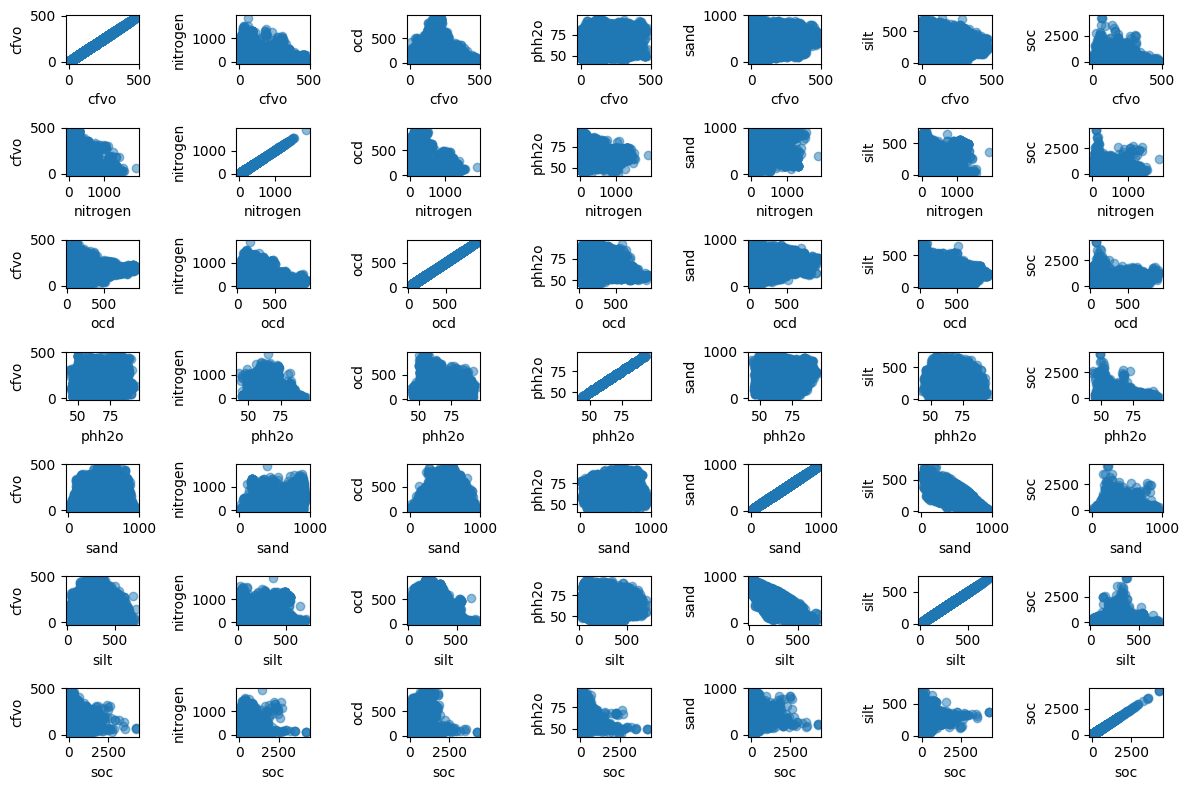

In [23]:
# Specify the columns for joint distribution
columns_for_joint_distribution = [ 'SOIL_cfvo_60.100cm_mean_0.01_deg',
     'SOIL_nitrogen_60.100cm_mean_0.01_deg', 'SOIL_ocd_60.100cm_mean_0.01_deg',
    'SOIL_phh2o_60.100cm_mean_0.01_deg', 'SOIL_sand_60.100cm_mean_0.01_deg','SOIL_silt_60.100cm_mean_0.01_deg',
    'SOIL_soc_60.100cm_mean_0.01_deg'
]

# Custom labels for the columns
custom_labels = [
    'cfvo',
    'nitrogen', 'ocd',
    'phh2o', 'sand','silt',
    'soc'
]

# Plot joint distributions using scatter plots
plt.figure(figsize=(12, 8))
for i, column1 in enumerate(columns_for_joint_distribution):
    for j, column2 in enumerate(columns_for_joint_distribution):
        plt.subplot(len(columns_for_joint_distribution), len(columns_for_joint_distribution), i * len(columns_for_joint_distribution) + j + 1)
        plt.scatter(train_df[column1], train_df[column2], alpha=0.5)
        plt.xlabel(custom_labels[i])
        plt.ylabel(custom_labels[j])
plt.tight_layout()
plt.show()



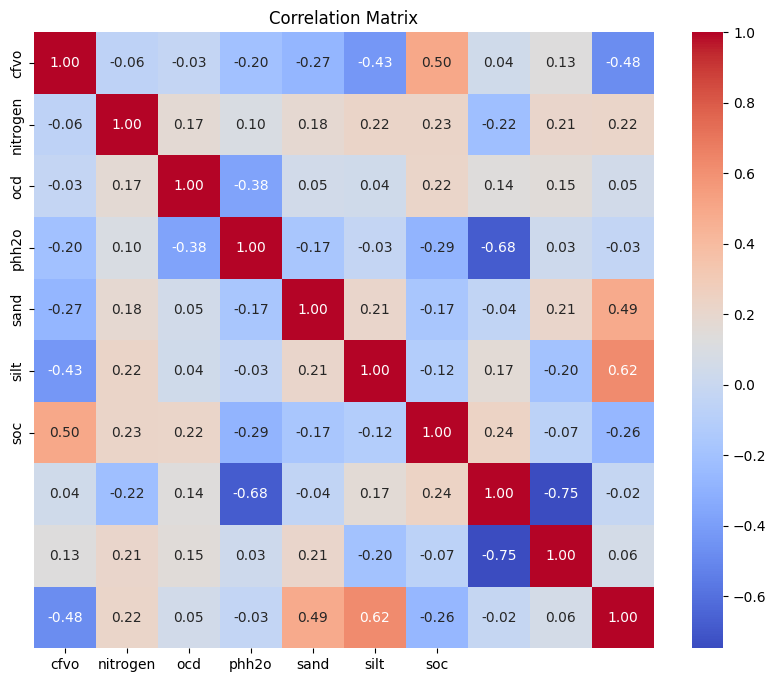

In [25]:
# Specify the columns for which you want to compute the correlation
columns_for_correlation = [
    'SOIL_bdod_60.100cm_mean_0.01_deg','SOIL_cec_60.100cm_mean_0.01_deg', 'SOIL_cfvo_60.100cm_mean_0.01_deg',
    'SOIL_clay_60.100cm_mean_0.01_deg', 'SOIL_nitrogen_60.100cm_mean_0.01_deg', 'SOIL_ocd_60.100cm_mean_0.01_deg',
    'SOIL_phh2o_60.100cm_mean_0.01_deg', 'SOIL_sand_60.100cm_mean_0.01_deg','SOIL_silt_60.100cm_mean_0.01_deg',
    'SOIL_soc_60.100cm_mean_0.01_deg'
]

# Compute the correlation matrix
correlation_matrix = train_df[columns_for_correlation].corr()

# Define custom labels for the columns
columns_for_joint_distribution = [
    'bdod','cec', 'cfvo',
    'clay', 'nitrogen', 'ocd',
    'phh2o', 'sand','silt',
    'soc'
]

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=custom_labels, yticklabels=custom_labels)
plt.title("Correlation Matrix")
plt.show()

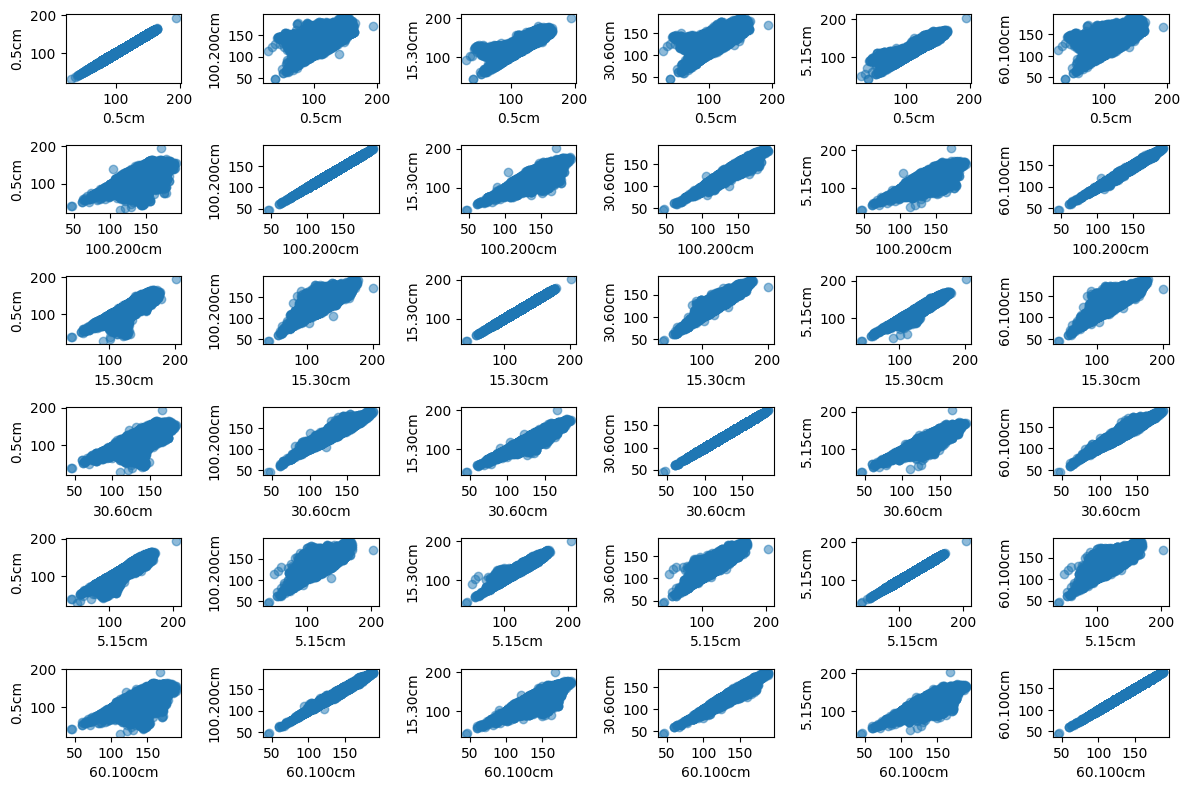

In [27]:
# Specify the columns for joint distribution
columns_for_joint_distribution = [ 
'SOIL_bdod_0.5cm_mean_0.01_deg', 'SOIL_bdod_100.200cm_mean_0.01_deg', 'SOIL_bdod_15.30cm_mean_0.01_deg', 'SOIL_bdod_30.60cm_mean_0.01_deg', 'SOIL_bdod_5.15cm_mean_0.01_deg', 'SOIL_bdod_60.100cm_mean_0.01_deg'
]

# Custom labels for the columns
custom_labels = [
    '0.5cm', '100.200cm', '15.30cm', '30.60cm', '5.15cm', '60.100cm'
]

# Plot joint distributions using scatter plots
plt.figure(figsize=(12, 8))
for i, column1 in enumerate(columns_for_joint_distribution):
    for j, column2 in enumerate(columns_for_joint_distribution):
        plt.subplot(len(columns_for_joint_distribution), len(columns_for_joint_distribution), i * len(columns_for_joint_distribution) + j + 1)
        plt.scatter(train_df[column1], train_df[column2], alpha=0.5)
        plt.xlabel(custom_labels[i])
        plt.ylabel(custom_labels[j])
plt.tight_layout()
plt.show()

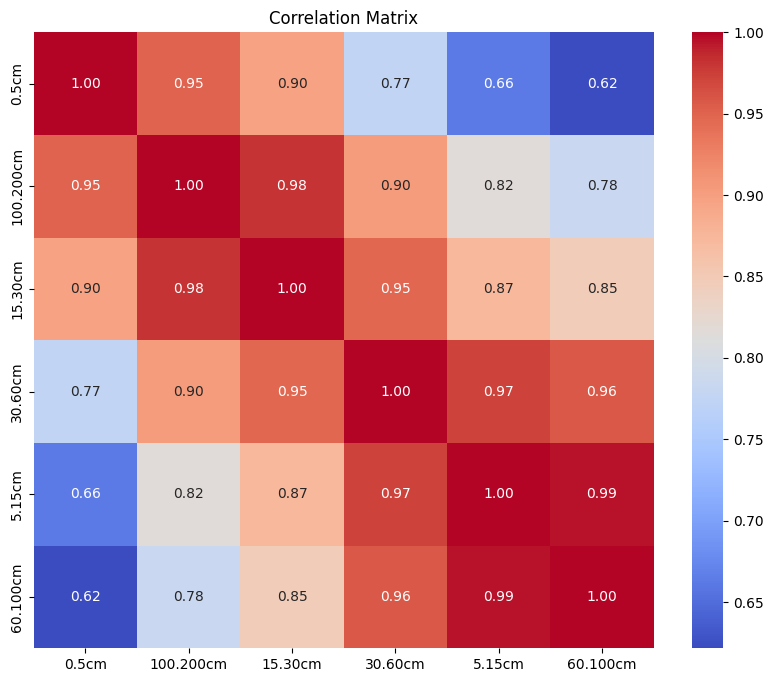

In [29]:
# Specify the columns for which you want to compute the correlation
columns_for_correlation = [ 
'SOIL_bdod_0.5cm_mean_0.01_deg','SOIL_bdod_5.15cm_mean_0.01_deg','SOIL_bdod_15.30cm_mean_0.01_deg', 'SOIL_bdod_30.60cm_mean_0.01_deg','SOIL_bdod_60.100cm_mean_0.01_deg','SOIL_bdod_100.200cm_mean_0.01_deg'
]

# Compute the correlation matrix
correlation_matrix = train_df[columns_for_correlation].corr()

# Define custom labels for the columns
custom_labels = [
    '0.5cm', '100.200cm', '15.30cm', '30.60cm', '5.15cm', '60.100cm'
]

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=custom_labels, yticklabels=custom_labels)
plt.title("Correlation Matrix")
plt.show()

#### MODIS

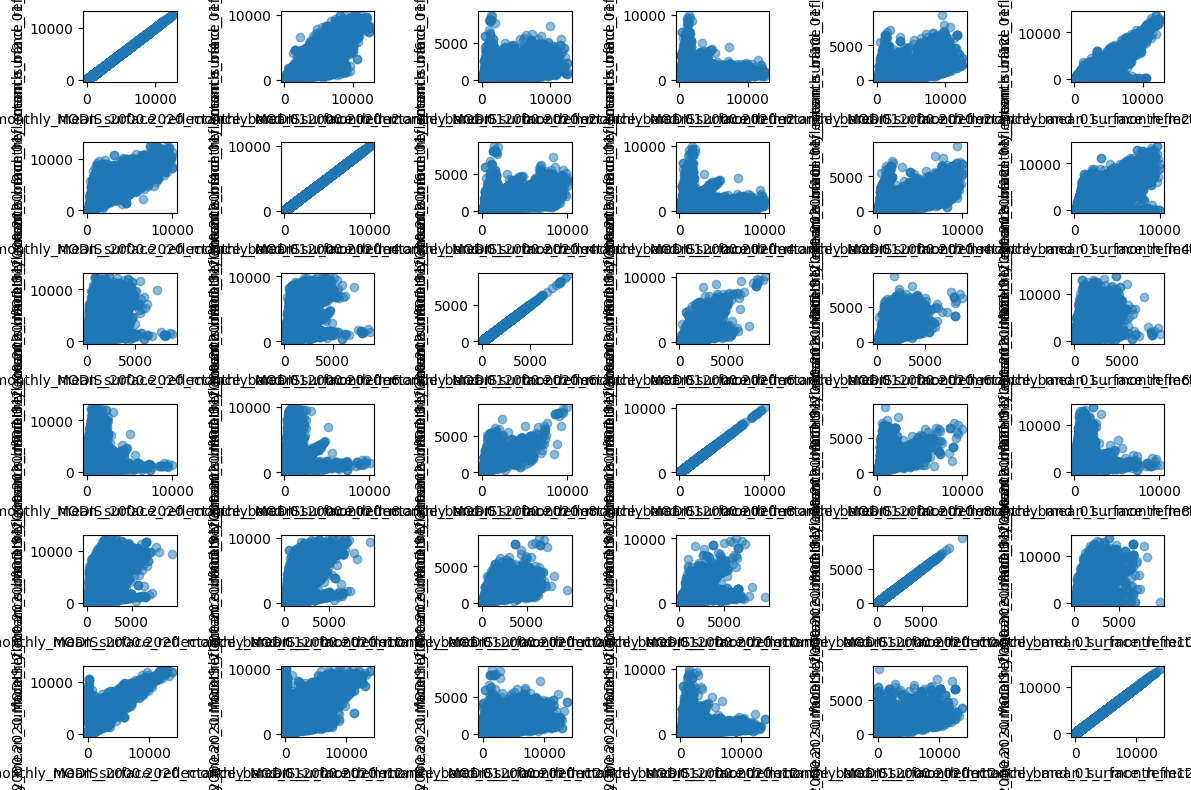

In [ ]:
# Specify the columns for joint distribution
columns_for_joint_distribution = [
    'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m2', 
    'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m4',
    'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m6',
    'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m8',
    'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10', 
    'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m12', 
]

# Plot joint distributions using scatter plots
plt.figure(figsize=(12, 8))
for i, column1 in enumerate(columns_for_joint_distribution):
    for j, column2 in enumerate(columns_for_joint_distribution):
        plt.subplot(len(columns_for_joint_distribution), len(columns_for_joint_distribution), i * len(columns_for_joint_distribution) + j + 1)
        plt.scatter(train_df[column1], train_df[column2], alpha=0.5)
        plt.xlabel(column1)
        plt.ylabel(column2)
plt.tight_layout()
plt.show()

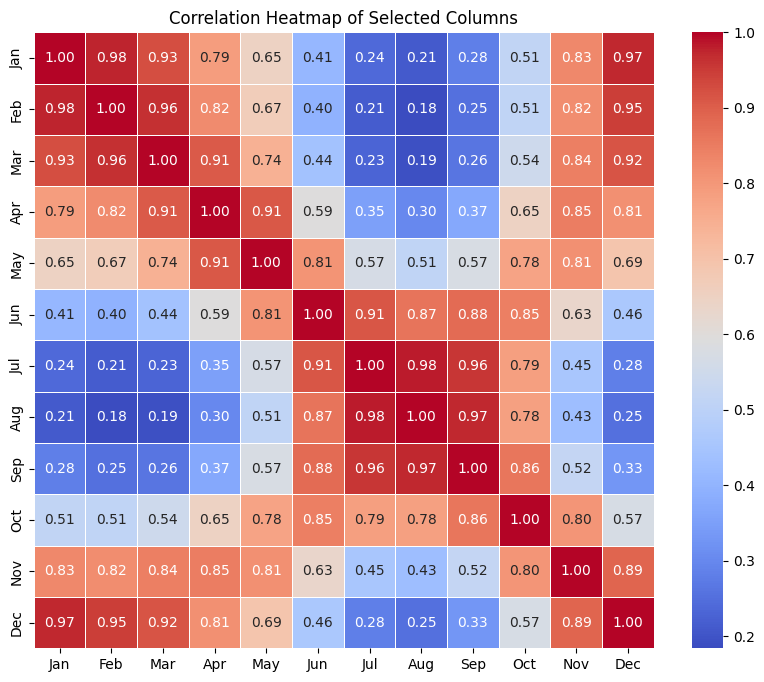

In [ ]:
# Specify custom labels for the columns
custom_labels = {
    'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1':'Jan', 
    'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m2': 'Feb',
    'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m3': 'Mar',
    'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m4': 'Apr',
    'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m5': 'May', 
    'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m6': 'Jun', 
    'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m7': 'Jul', 
    'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m8': 'Aug',
    'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m9': 'Sep',
    'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10': 'Oct',
    'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11': 'Nov', 
    'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m12': 'Dec', }

# Rename the columns in the correlation matrix
correlation_matrix = correlation_matrix.rename(index=custom_labels, columns=custom_labels)

# Plot the heatmap with custom labels
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("MODIS_2000.2020_monthly_mean_surface_reflectance for every month")
plt.show()


#### VOD

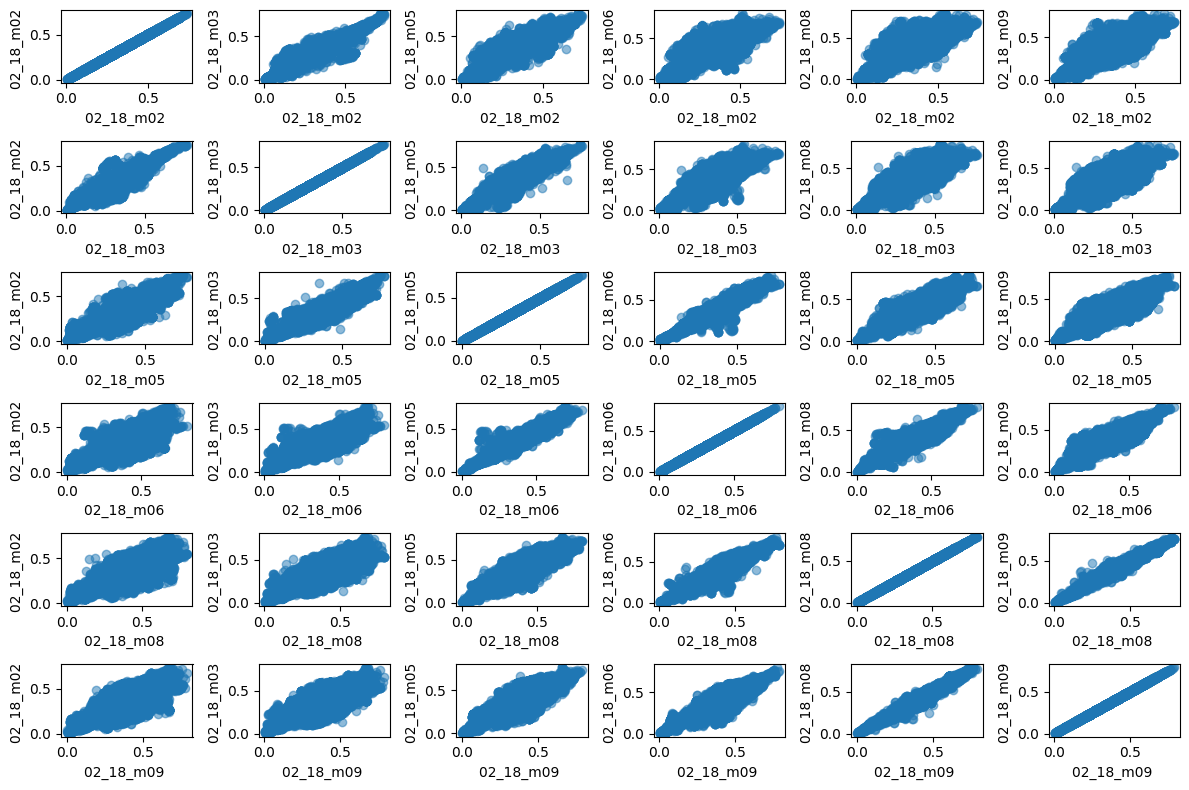

In [32]:
# Specify the columns for joint distribution
columns_for_joint_distribution = [ 
'VOD_C_2002_2018_multiyear_mean_m02', 'VOD_C_2002_2018_multiyear_mean_m03','VOD_C_2002_2018_multiyear_mean_m05', 'VOD_C_2002_2018_multiyear_mean_m06', 'VOD_C_2002_2018_multiyear_mean_m08', 'VOD_C_2002_2018_multiyear_mean_m09'
]

# Custom labels for the columns
custom_labels = [
   '02_18_m02 ', '02_18_m03 ', '02_18_m05 ', '02_18_m06 ', '02_18_m08 ', '02_18_m09 '
]

# Plot joint distributions using scatter plots
plt.figure(figsize=(12, 8))
for i, column1 in enumerate(columns_for_joint_distribution):
    for j, column2 in enumerate(columns_for_joint_distribution):
        plt.subplot(len(columns_for_joint_distribution), len(columns_for_joint_distribution), i * len(columns_for_joint_distribution) + j + 1)
        plt.scatter(train_df[column1], train_df[column2], alpha=0.5)
        plt.xlabel(custom_labels[i])
        plt.ylabel(custom_labels[j])
plt.tight_layout()
plt.show()

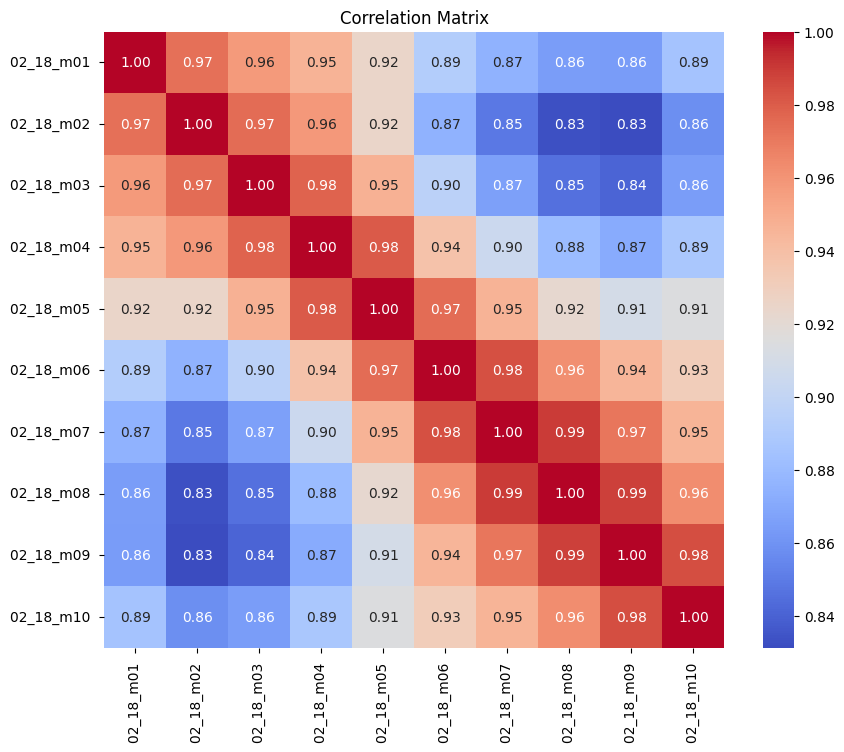

In [33]:
# Specify the columns for which you want to compute the correlation
columns_for_correlation = [ 
'VOD_C_2002_2018_multiyear_mean_m01', 'VOD_C_2002_2018_multiyear_mean_m02', 'VOD_C_2002_2018_multiyear_mean_m03', 'VOD_C_2002_2018_multiyear_mean_m04', 'VOD_C_2002_2018_multiyear_mean_m05', 'VOD_C_2002_2018_multiyear_mean_m06', 'VOD_C_2002_2018_multiyear_mean_m07', 'VOD_C_2002_2018_multiyear_mean_m08', 'VOD_C_2002_2018_multiyear_mean_m09', 'VOD_C_2002_2018_multiyear_mean_m10'
]

# Compute the correlation matrix
correlation_matrix = train_df[columns_for_correlation].corr()

# Define custom labels for the columns
custom_labels = [
    '02_18_m01 ', '02_18_m02 ', '02_18_m03 ', '02_18_m04 ', '02_18_m05 ', '02_18_m06 ', '02_18_m07 ', '02_18_m08 ', '02_18_m09 ', '02_18_m10 '
]

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=custom_labels, yticklabels=custom_labels)
plt.title("Correlation Matrix")
plt.show()

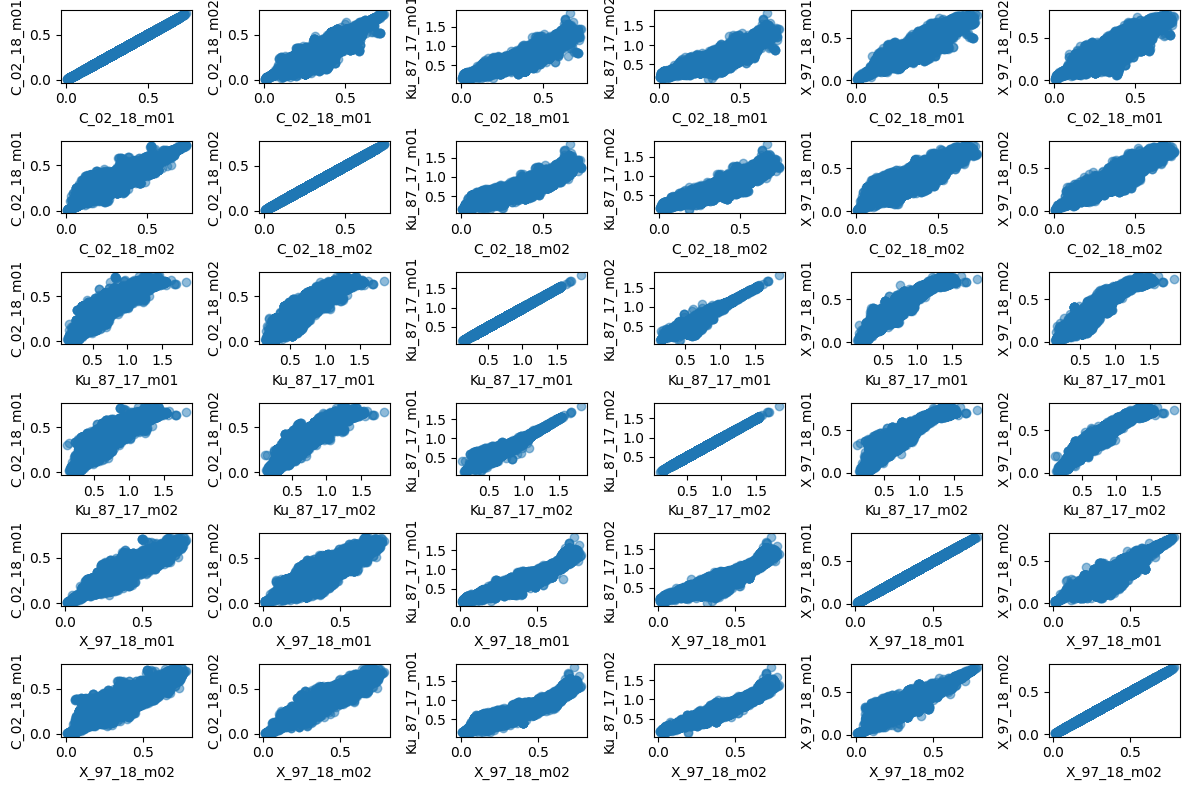

In [34]:
# Specify the columns for joint distribution
columns_for_joint_distribution = [ 
'VOD_C_2002_2018_multiyear_mean_m01','VOD_C_2002_2018_multiyear_mean_m02', 'VOD_Ku_1987_2017_multiyear_mean_m01','VOD_Ku_1987_2017_multiyear_mean_m02','VOD_X_1997_2018_multiyear_mean_m01','VOD_X_1997_2018_multiyear_mean_m02'
]

# Custom labels for the columns
custom_labels = [
    'C_02_18_m01','C_02_18_m02', 'Ku_87_17_m01','Ku_87_17_m02','X_97_18_m01','X_97_18_m02'
]

# Plot joint distributions using scatter plots
plt.figure(figsize=(12, 8))
for i, column1 in enumerate(columns_for_joint_distribution):
    for j, column2 in enumerate(columns_for_joint_distribution):
        plt.subplot(len(columns_for_joint_distribution), len(columns_for_joint_distribution), i * len(columns_for_joint_distribution) + j + 1)
        plt.scatter(train_df[column1], train_df[column2], alpha=0.5)
        plt.xlabel(custom_labels[i])
        plt.ylabel(custom_labels[j])
plt.tight_layout()
plt.show()

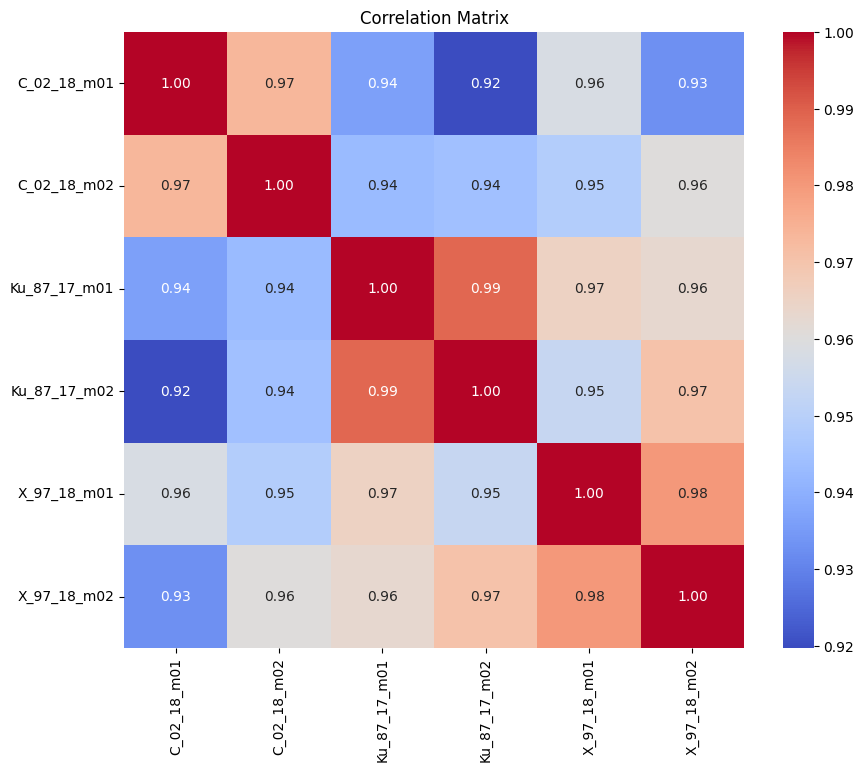

In [35]:
# Specify the columns for which you want to compute the correlation
columns_for_correlation = [ 
'VOD_C_2002_2018_multiyear_mean_m01','VOD_C_2002_2018_multiyear_mean_m02', 'VOD_Ku_1987_2017_multiyear_mean_m01','VOD_Ku_1987_2017_multiyear_mean_m02','VOD_X_1997_2018_multiyear_mean_m01','VOD_X_1997_2018_multiyear_mean_m02'
]

# Compute the correlation matrix
correlation_matrix = train_df[columns_for_correlation].corr()

# Define custom labels for the columns
custom_labels = [
    'C_02_18_m01','C_02_18_m02', 'Ku_87_17_m01','Ku_87_17_m02','X_97_18_m01','X_97_18_m02'
]

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=custom_labels, yticklabels=custom_labels)
plt.title("Correlation Matrix")
plt.show()